In [180]:
from pathlib import Path

import matplotlib.pyplot as plt

import h5py
import numpy as np
from magtense.utils import plot_M_thin_film

from koopmag.database import create_db_mp
from koopmag.utils import plot_dynamics

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax) -> None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

In [181]:
def plot_avg(data, ax, ts=None, linestyle="-", linewidth=2, annot=""):

    if ts is None:
        ts = np.arange(data.shape[0])

    mg_x = data[:, :, :, 0].reshape(data.shape[0], -1)
    mg_y = data[:, :, :, 1].reshape(data.shape[0], -1)
    mg_z = data[:, :, :, 2].reshape(data.shape[0], -1)

    avg_mg_x = np.mean(mg_x, axis=1)
    avg_mg_y = np.mean(mg_y, axis=1)
    avg_mg_z = np.mean(mg_z, axis=1)

    ax.plot(ts, avg_mg_x, label=f'mg_x {annot}', linestyle=linestyle, color="C0", linewidth=linewidth)
    ax.plot(ts, avg_mg_y, label=f'mg_y {annot}', linestyle=linestyle, color="C1", linewidth=linewidth)
    ax.plot(ts, avg_mg_z, label=f'mg_z {annot}', linestyle=linestyle, color="C2", linewidth=linewidth)

    ax.legend(ncol=2)


In [182]:
datapath = Path().cwd().parent / "data"

try:
    db = h5py.File(datapath / "120_150_40_16.h5", "r")
    print("Successfully loaded data")

    print("Attributes of database:")
    for key in db.attrs:
        print(f"{key}: {db.attrs[key]}")

    print("\nData in the database:")
    for key in db:
        print(f"{key}: {db[key].shape}")

    # extract external fields
    Hs = np.array(db["field"])

    # extract data
    DATA = np.array(db["sequence"])

    db.close()

except FileNotFoundError:
    print("Database not found. Please try again.")

Successfully loaded data
Attributes of database:
grid_size: [5.e-07 2.e-07 3.e-09]
h_ext_angle: [  0 360]
h_ext_norm: [ 0 50]
res: [40 16  1]
seed: 0
t_per_step: 1.5e-11
t_steps: 150

Data in the database:
field: (120, 3)
sequence: (120, 150, 40, 16, 3)


In [183]:
n_seq, n_tsteps, data_dim = *DATA.shape[:2], DATA.shape[2:]

In [184]:
class SlidingWindowDataset(Dataset):
    def __init__(self, X, U, window_size=32, step=1) -> None:
        """
        X, Y: torch.Tensor of shape (n_seq, seq_length, H, W, C)
        U: torch.Tensor of shape (n_seq, seq_length, action_dim)
        window_size: length of each subsequence
        step: sliding window step size
        """
        n_seq, seq_len = X.shape[:2]
        self.indices = []
        for seq_idx in range(n_seq):
            for start in range(0, seq_len - window_size + 1, step):
                self.indices.append((seq_idx, start))
        self.X = X
        self.U = U
        self.window_size = window_size

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        seq_idx, start = self.indices[idx]
        end = start + self.window_size
        x_window = self.X[seq_idx, start:end]  # (window_size, H, W, C)
        u_window = self.U[seq_idx, start:end]  # (window_size, action_dim)
        return x_window, u_window


In [185]:
Xtorch = torch.tensor(DATA, dtype=torch.float32)
Htorch = torch.stack([
    torch.stack([torch.tensor(Hs[i], dtype=torch.float32) for _ in range(n_tsteps)])
    for i in range(n_seq)])

print(f"H shape: {Htorch.shape} (n_seq, n_tsteps, 3)")

train_size = int(0.8 * n_seq)
test_size = n_seq - train_size

torch.manual_seed(0)
np.random.seed(0)
indices = torch.randperm(n_seq)
train_indices = indices[:train_size]
test_indices = indices[train_size:]


Xtrain, Htrain = Xtorch[train_indices], Htorch[train_indices]
Xtest,  Htest = Xtorch[test_indices], Htorch[test_indices]
print(f"Train set shape: {Xtrain.shape} (n_seq, n_tsteps, n_x, n_y, 3)")
print(f"Test set shape: {Xtest.shape} (n_seq, n_tsteps, n_x, n_y, 3)")

H shape: torch.Size([120, 150, 3]) (n_seq, n_tsteps, 3)
Train set shape: torch.Size([96, 150, 40, 16, 3]) (n_seq, n_tsteps, n_x, n_y, 3)
Test set shape: torch.Size([24, 150, 40, 16, 3]) (n_seq, n_tsteps, n_x, n_y, 3)


In [186]:
window_size = 32
step = 1

batch_size = 32

train_dataset = SlidingWindowDataset(Xtrain, Htrain, window_size=window_size, step=step)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SlidingWindowDataset(Xtest, Htest, window_size=window_size, step=step)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

og_dataset = TensorDataset(Xtorch)
og_loader = DataLoader(og_dataset, batch_size=batch_size, shuffle=False)

### Koopman Autoencoder

In [187]:
class BottleNeck(nn.Module):

    def __init__(self, in_channels, mid_channels, out_channels, act_fn=nn.ReLU) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            act_fn(),
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            act_fn(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            act_fn(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False),
        )

    def forward(self, x) -> torch.Tensor:
        return self.conv(x) + x
    

class KoopmanAE(nn.Module):

    def __init__(self, chns, latent_dim, act_fn=nn.ReLU) -> None:
        super().__init__()
        self.chns = chns
        self.act_fn = act_fn
        self.latent_dim = latent_dim

        self.flat = nn.Flatten()

        self._init_encoder()
        self.fc_encoder = nn.Linear(chns[-1] * (40 // 2**len(chns)) * (16 // 2**len(chns)), latent_dim)

        self.fc_decoder = nn.Linear(latent_dim, chns[-1] * (40 // 2**len(chns)) * (16 // 2**len(chns)))
        self._init_decoder()
        self.tanh = nn.Tanh()

    def _init_encoder(self) -> None:

        encoder_blocks = []
        in_ch = 3
        for ch in self.chns:
            encoder_blocks.append(nn.Conv2d(in_ch, ch, kernel_size=3, padding=1, stride=2, bias=False))
            encoder_blocks.append(BottleNeck(ch, ch // 2, ch, act_fn=self.act_fn))
            in_ch = ch
        
        self.encoder_block = nn.Sequential(*encoder_blocks)
    
    def _init_decoder(self) -> None:

        decoder_blocks = []
        reversed_chns = self.chns[::-1]
        in_ch = reversed_chns[0]
        for ch in reversed_chns[1:]:
            decoder_blocks.append(BottleNeck(in_ch, in_ch // 2, in_ch, act_fn=self.act_fn))
            decoder_blocks.append(nn.ConvTranspose2d(in_ch, ch, kernel_size=3, padding=1, output_padding=1, stride=2, bias=False))
            in_ch = ch

        decoder_blocks.append(BottleNeck(in_ch, in_ch // 2, in_ch, act_fn=self.act_fn))
        decoder_blocks.append(nn.ConvTranspose2d(in_ch, 3, kernel_size=3, padding=1, output_padding=1, stride=2, bias=False))

        self.decoder_block = nn.Sequential(*decoder_blocks)

    def encode(self, x) -> torch.Tensor:
        x = self.encoder_block(x)    # encode X: (n x m)  -> Xtilde: (n x d)
        x = self.flat(x)             # flatten Xtilde: (n x d)
        x = self.fc_encoder(x)
        return x
    
    def decode(self, x) -> torch.Tensor:
        x = self.fc_decoder(x)
        x = x.view(-1, self.chns[-1], 40 // 2**len(self.chns), 16 // 2**len(self.chns))
        x = self.decoder_block(x)    # decode Xtilde: (n x d)  -> X: (n x m)
        x = self.tanh(x)            # apply activation function
        return x
    
    def forward(self, X) -> torch.Tensor:
        X = X.permute(0, 1, 4, 2, 3)    # (batch_size, nseq, n_x, n_y, 3) -> (batch_size, nseq, 3, n_x, n_y)
        batch_size, nseq, nchan, n_x, n_y = X.shape
        X = X.view(-1, nchan, n_x, n_y)
        x = self.encode(X)    # encode X: (n x m)  -> Xtilde: (n x d)
        x = self.decode(x)
        x = x.view(batch_size, nseq, nchan, n_x, n_y)    # decode Xtilde: (n x d)  -> X: (n x m)
        x = x.permute(0, 1, 3, 4, 2)    # (batch_size, nseq, n_x, n_y, 3)
        return x
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

chns = [256, 128, 64]
latent_dim = 64
act_fn = nn.Tanh

ae = KoopmanAE(chns=chns, latent_dim=latent_dim, act_fn=act_fn).to(device)

dummy_data = torch.randn(10, 32, 40, 16, 3).to(device)
dummy_out = ae(dummy_data)

assert dummy_out.shape == dummy_data.shape, f"Output shape {dummy_out.shape} does not match input shape {dummy_data.shape}"

In [142]:
optimizer = optim.Adam(ae.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

epochs = 20
valid_every = 2
train_loss = np.zeros(epochs)
valid_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    for (xtrain, _) in trainloader:

        xtrain = xtrain.to(device)

        ae.train()
        optimizer.zero_grad()

        # forward pass
        yhat = ae(xtrain)

        # compute loss
        loss = loss_fn(yhat, xtrain)
        
        # backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_loss[epoch] = running_loss / train_size

    if epoch % valid_every == valid_every - 1:
        ae.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            for (xtest, _) in testloader:
                xtest = xtest.to(device)
                yhat = ae(xtest)
                v_loss = loss_fn(yhat, xtest)
                running_loss_val += v_loss.item()
            valid_loss.append(running_loss_val / test_size)

        print(f"Epoch {epoch+1}/{epochs}, training loss: {train_loss[epoch]:.4f}, validation loss: {valid_loss[-1]:.4f}")

Epoch 2/20, training loss: 0.0352, validation loss: 0.0198
Epoch 4/20, training loss: 0.0185, validation loss: 0.0113
Epoch 6/20, training loss: 0.0135, validation loss: 0.0088
Epoch 8/20, training loss: 0.0110, validation loss: 0.0079
Epoch 10/20, training loss: 0.0092, validation loss: 0.0067
Epoch 12/20, training loss: 0.0078, validation loss: 0.0056
Epoch 14/20, training loss: 0.0069, validation loss: 0.0055
Epoch 16/20, training loss: 0.0064, validation loss: 0.0066
Epoch 18/20, training loss: 0.0059, validation loss: 0.0051
Epoch 20/20, training loss: 0.0054, validation loss: 0.0048


In [143]:
torch.save(ae.state_dict(), datapath / "ae_weights.pth")

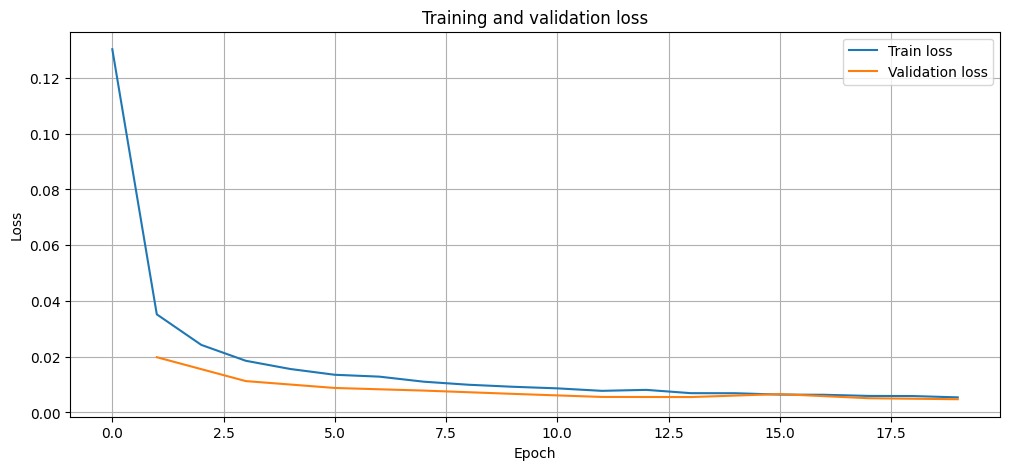

In [144]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train_loss, label="Train loss")
ax.plot(np.arange(valid_every - 1, epochs, valid_every), valid_loss, label="Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and validation loss")
ax.legend()
ax.grid()
plt.show()

In [11]:
ae.load_state_dict(torch.load(datapath / "ae_weights.pth", weights_only=True))

<All keys matched successfully>

In [12]:
ae.eval()

data_rec = []
with torch.no_grad():
    for (xtest,) in og_loader:
        xtest = xtest.to(device)
        yhat = ae(xtest)
        data_rec.append(yhat.cpu().numpy())

data_rec = np.concatenate(data_rec, axis=0)

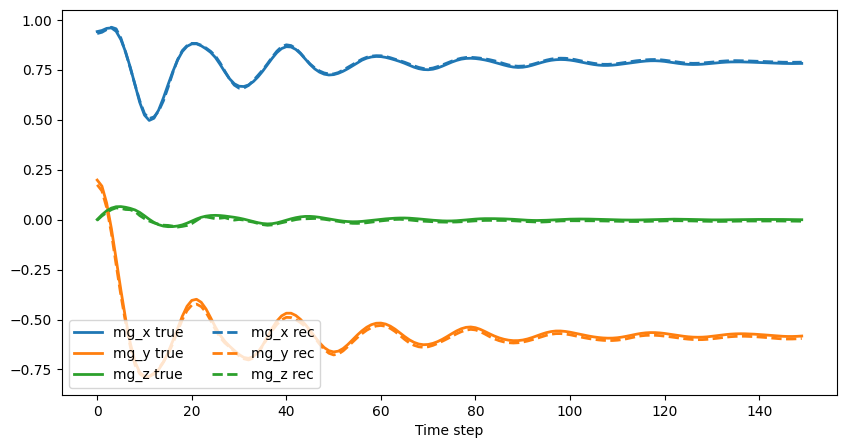

In [13]:
field_idx = test_indices[0]

fig, ax = plt.subplots(figsize=(10, 5))

plot_avg(DATA[field_idx], ax, linestyle="-", annot="true")
plot_avg(data_rec[field_idx], ax, linestyle="--", annot="rec")
ax.set_xlabel("Time step")
plt.show()

In [188]:
class DeepKoopman(nn.Module):

    def __init__(self, autoencoder, learn_A=False, method="pinv", lam=1e-1) -> None:
        super().__init__()
        
        self.autoencoder = autoencoder
        self.latent_dim = autoencoder.latent_dim
        self.learn_A = learn_A
        self.method = method
        self.lam = lam

        if learn_A:
            self.A = nn.Linear(self.latent_dim, self.latent_dim, bias=False) # shape (d, d)
        else:
            self.register_buffer("A", torch.empty(self.latent_dim, self.latent_dim)) # shape (d, d)

        self.B = nn.Linear(3, self.latent_dim, bias=False) # shape (n_magnetization, d)


    def compute_linear_operator_pinv(self, Xtilde, Ytilde) -> None:
        A = torch.linalg.pinv(Xtilde, rcond=1e-2) @ Ytilde
        self.A.data.copy_(A)
    

    def compute_linear_operator_tikh(self, Xtilde, Ytilde) -> None:
    # Xtilde: (n, d), Ytilde: (n, d)
        XtX = Xtilde.T @ Xtilde             # (d, d)
        d   = XtX.shape[0]
        reg = self.lam * torch.eye(d, device=XtX.device)
        A   = torch.linalg.solve(XtX + reg, Xtilde.T @ Ytilde)
        self.A.data.copy_(A)
        

    def compute_linear_operator(self, Xtilde, Ytilde) -> None:
        
        # flatten from (batch_size, nseq, d) to (batch_size * seq, d)
        b, nseq, d = Xtilde.shape
        xtilde = Xtilde.reshape(b * nseq, d)
        ytilde = Ytilde.view(b * nseq, d) 

        if self.method == "pinv":
            self.compute_linear_operator_pinv(xtilde, ytilde)
        elif self.method == "tikh":
            self.compute_linear_operator_tikh(xtilde, ytilde)
        else:
            raise ValueError(f"Unknown method: {self.method}. Use 'pinv' or 'tikh'.")
        
        if torch.any(torch.isnan(self.A.data)):
            raise ValueError("nan values detected in A matrix")


    def forward(self, X, U) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        params:
        X: input data (n x m)
        Y: target data (n x m)
        U: external effect (n x 3)
        '''
        X = X.permute(0, 1, 4, 2, 3)  # switch data dimensions to match pytorch conv layer
        batch_size, nseq, nchan, n_x, n_y = X.shape     # extract dimensions
        T_half = nseq // 2

        X = X.view(batch_size*nseq, nchan, n_x, n_y)  # reshape to (batch_size*nseq, nchan, n_x, n_y)

        # encode data 
        X = self.autoencoder.encode(X)    # encode X: (batch_size*nseq, nchan, n_x, n_y)  -> Xtilde: (batch_size*nseq, d)

        # reshape back to (batch_size, nseq, ...)
        X = X.view(batch_size, nseq, -1)  # reshape to (batch_size, nseq, d)

        Xtilde = X[:, :-1, :]       # X data
        Ytilde = X[:, 1:, :]        # Y data

        # apply B to U:
        U = U.view(batch_size * nseq, -1)  # reshape to (batch_size, nseq, nchan)
        Bu = self.B(U)
        Bu = Bu.view(batch_size, nseq, -1)  # reshape to (batch_size, nseq, d)

        ext_effect = self.B(U)  # shape (n//2 x d)
        ext_effect = ext_effect.view(batch_size, nseq, -1)  # reshape to (batch_size, nseq, d)

        # extract first half of external effect
        ext_effect = ext_effect[:, :T_half, :]  # take first half of the sequence

        # compute recursive predictions
        if not self.learn_A:

            # compute linear operator using pseudo-inverse or tikhonov regularization
            self.compute_linear_operator(
                Xtilde[:, :T_half,:], Ytilde[:, :T_half,:] - ext_effect
            )

            # compute predictions
            Ytilde_pred_list = [Xtilde[:, 0, :].matmul(self.A) + Bu[:, 0, :]] 
            for t in range(1, nseq-1):
                next_pred = Ytilde_pred_list[t-1] @ self.A + Bu[:, t, :]
                Ytilde_pred_list.append(next_pred)

        # If A is learned as a parameter:
        else:
            Ytilde_pred_list = [self.A(Xtilde[:, 0, :]) + Bu[:, 0, :]] 
            for t in range(1, nseq-1):
                next_pred = self.A(Ytilde_pred_list[-1]) + Bu[:, t, :]
                Ytilde_pred_list.append(next_pred)
        
        Ytilde_pred = torch.stack(Ytilde_pred_list, dim=1)

        # concatenate Xtilde and Ytilde_pred for efficient decoding
        cat_data = torch.cat((Xtilde.reshape(-1, self.latent_dim), Ytilde_pred.reshape(-1, self.latent_dim)), dim=0)

        decoded = self.autoencoder.decode(cat_data)

        Xhat = decoded[:batch_size*(nseq-1), :, :, :]  # shape (batch_size*nseq, n_x, n_y, 3)
        Xhat = Xhat.view(batch_size, nseq-1, nchan, n_x, n_y)  # reshape to (batch_size, nseq-1, n_x, n_y, 3)

        Xhat = Xhat.permute(0, 1, 3, 4, 2)  # switch data dimensions back to (n_seq, n_tsteps - 1, n_x, n_y, 3)

        Yhat = decoded[batch_size*(nseq-1):, :, :, :]  # shape (batch_size*nseq, n_x, n_y, 3)
        Yhat = Yhat.view(batch_size, nseq-1, nchan, n_x, n_y)

        Yhat = Yhat.permute(0, 1, 3, 4, 2)  # switch data dimensions back to (n_seq, n_tsteps - 1, n_x, n_y, 3)

        return Xhat, Yhat
    
    
    def predict(self, X, U) -> torch.Tensor:
        '''
        params:
        X: first observation (n_batch, n_x, n_y, 3)
        T: number of time steps to predict
        U: external effect (n_batch, T, 3)
        '''
    
        assert len(X.shape) == 4, f"X should be of shape (n_batch, n_x, n_y, 3), but got {X.shape}"

        self.eval()

        T = U.shape[1]

        with torch.no_grad():
            n_batch, n_x, n_y, n_chan = X.shape
            X = X.permute(0, 3, 1, 2)  # switch data dimensions to match pytorch conv layer
            Xtilde0 = self.autoencoder.encode(X)    # encode X: (n_batch, n_chan, n_x, n_y)  -> Xtilde: (n_batch x latent_dim)

            U = U.view(n_batch * T, -1)  # reshape to (batch_size, nseq, nchan)
            Bu = self.B(U)
            Bu = Bu.view(n_batch, T, -1)  # reshape to (batch_size, nseq, d)
            # If A is computed using pseudo-inverse or tikhonov regularization:

            Ytilde_pred = [Xtilde0]
            if not self.learn_A:
                for t in range(T):
                    Ytilde_pred.append(Ytilde_pred[-1].matmul(self.A) + Bu[:, t, :])

            # If A is learned as a parameter:
            else:
                for t in range(T):
                    next_pred = self.A(Ytilde_pred[-1]) + Bu[:, t, :]
                    Ytilde_pred.append(next_pred)

            # concatenate along dim 1 (time dimension)
            Ytilde_pred = torch.stack(Ytilde_pred, dim=1)  # -> (n_batch, T+1, latent_dim)

            # reshape for decoding
            Ytilde_pred = Ytilde_pred.view(n_batch * (T + 1), -1) # (n_batch, T+1, latent_dim) -> (n_batch*(T+1), latent_dim)
            Yhat = self.autoencoder.decode(Ytilde_pred)
            Yhat = Yhat.view(n_batch, T+1, n_chan, n_x, n_y)
            Yhat = Yhat.permute(0, 1, 3, 4, 2)
        return Yhat

In [189]:
LEARN_A = True

koopman = DeepKoopman(
    autoencoder=ae, 
    learn_A=LEARN_A,
    method="tikh",
    lam=5.
    ).to(device)


In [190]:
PRETRAIN_AE = False
if PRETRAIN_AE:
    koopman.autoencoder.load_state_dict(torch.load(datapath / "ae_weights.pth", weights_only=True))
    
criterion = nn.MSELoss()

In [191]:
dummy_X = torch.ones((20, 50, 40, 16, 3)).to(device)
dummy_U = torch.ones((20, 50, 3)).to(device)

x_dummy, y_dummy = koopman(dummy_X, dummy_U)
print(x_dummy.shape, y_dummy.shape)
pred_dummy = koopman.predict(dummy_X[:, 0, :, :, :], dummy_U)
print(pred_dummy.shape)
del dummy_X, dummy_U, x_dummy, y_dummy

torch.Size([20, 49, 40, 16, 3]) torch.Size([20, 49, 40, 16, 3])
torch.Size([20, 51, 40, 16, 3])


In [192]:
optimizer = optim.Adam(koopman.parameters(), lr=5e-4)

epochs = 20
valid_every = 1
n_rep = 1

train_loss = np.zeros(epochs)
valid_loss = []

for epoch in range(epochs):

    running_loss = 0.0
    for (xtrain, utrain) in trainloader:
        
        xtrain, utrain = xtrain.to(device), utrain.to(device)

        koopman.train()
        optimizer.zero_grad()

        xhat, yhat = koopman(xtrain,  U=utrain)

        loss = criterion(xhat, xtrain[:,:-1,:,:,:]) + criterion(yhat, xtrain[:,1:,:,:,:])

        loss.backward()
        optimizer.step()
            
        running_loss += loss.item()
    
    train_loss[epoch] = running_loss / n_seq

    if epoch % valid_every == valid_every - 1:
        koopman.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            for (xtest, utest) in testloader:

                xtest, utest = xtest.to(device), utest.to(device)

                xhat, yhat = koopman(xtest, U=utest)

                v_loss = criterion(xhat, xtest[:,:-1,:,:,:]) + criterion(yhat, xtest[:,1:,:,:,:])
                running_loss_val += v_loss.item()
            valid_loss.append(running_loss_val / test_size)
        print(f"Epoch {epoch+1}, Training loss: {train_loss[epoch]:.4f}, Validation Loss: {valid_loss[-1]:.4f}")

Epoch 1, Training loss: 0.1835, Validation Loss: 0.3861
Epoch 2, Training loss: 0.0683, Validation Loss: 0.2018
Epoch 3, Training loss: 0.0592, Validation Loss: 0.1408
Epoch 4, Training loss: 0.0545, Validation Loss: 0.2068
Epoch 5, Training loss: 0.0522, Validation Loss: 0.1561
Epoch 6, Training loss: 0.0505, Validation Loss: 0.1932
Epoch 7, Training loss: 0.0481, Validation Loss: 0.1427
Epoch 8, Training loss: 0.0431, Validation Loss: 0.1430
Epoch 9, Training loss: 0.0403, Validation Loss: 0.1055
Epoch 10, Training loss: 0.0360, Validation Loss: 0.1464
Epoch 11, Training loss: 0.0336, Validation Loss: 0.1175
Epoch 12, Training loss: 0.0342, Validation Loss: 0.1257
Epoch 13, Training loss: 0.0316, Validation Loss: 0.1643
Epoch 14, Training loss: 0.0295, Validation Loss: 0.1299
Epoch 15, Training loss: 0.0300, Validation Loss: 0.1530
Epoch 16, Training loss: 0.0279, Validation Loss: 0.1053
Epoch 17, Training loss: 0.0267, Validation Loss: 0.0793
Epoch 18, Training loss: 0.0255, Validat

In [ ]:
#torch.save(koopman.state_dict(), datapath / "koopman_weights.pth")

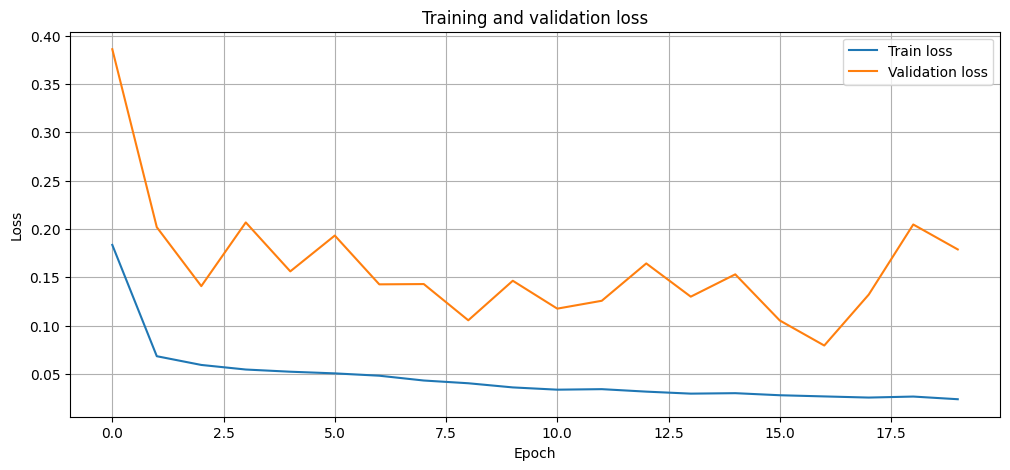

In [193]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train_loss, label="Train loss")
ax.plot(np.arange(valid_every - 1, epochs, valid_every), valid_loss, label="Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and validation loss")
ax.legend()
ax.grid()
plt.show()

In [170]:
koopman.load_state_dict(torch.load(datapath / "koopman_weights.pth", weights_only=True))
koopman = koopman.to(device)    

In [194]:
koopman.eval()

Xinit = Xtorch[test_indices, 0, :, :, :].to(device)
Utest = Htorch[test_indices, :-1, :].to(device)

Ypreds = koopman.predict(Xinit, Utest).cpu().numpy()

del Xinit, Utest

In [195]:
Ypreds.shape

(24, 150, 40, 16, 3)

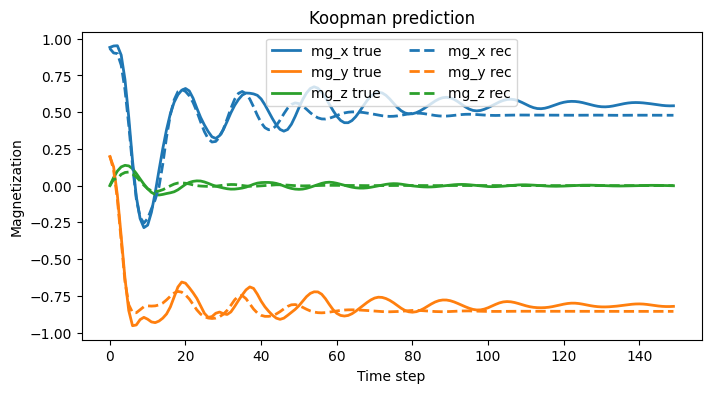

In [196]:
field_idx = 5

fig, ax = plt.subplots(figsize=(8, 4))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(Ypreds[field_idx], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title="Koopman prediction")
plt.show()

In [197]:
koopman.eval()

Xinit = Xtorch[test_indices, :, :, :, :].to(device)

Xrec = koopman.autoencoder(Xinit).detach().cpu().numpy()

del Xinit

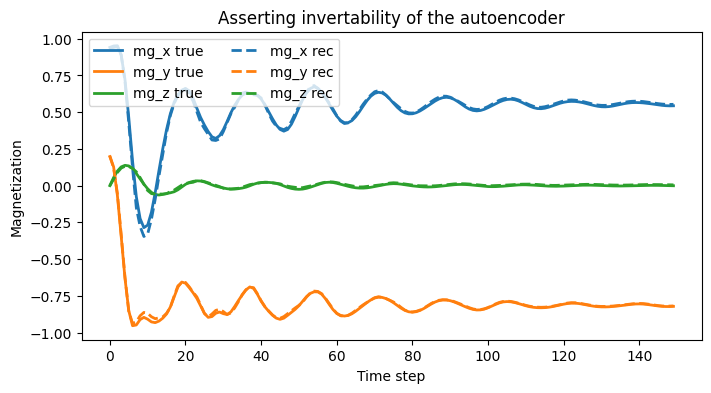

In [198]:
field_idx = 5

fig, ax = plt.subplots(figsize=(8, 4))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(Xrec[field_idx], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title="Asserting invertability of the autoencoder")
plt.show()

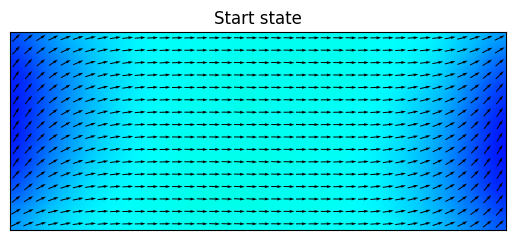

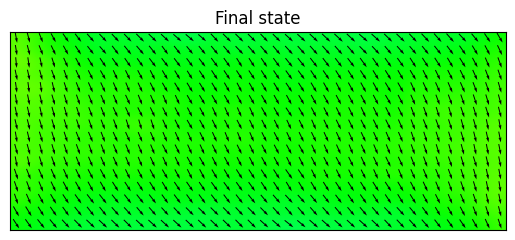

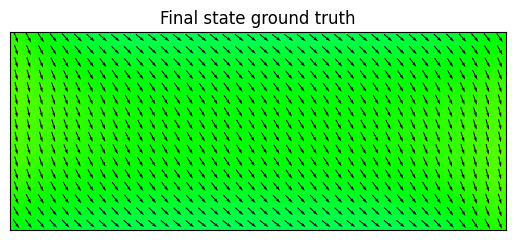

In [161]:
res = np.array([40, 16, 1])

plot_M_thin_film(Ypreds[field_idx][0], res, "Start state")
plot_M_thin_film(Ypreds[field_idx][-1], res, "Final state")
plot_M_thin_film(DATA[test_indices[field_idx]][-1], res, "Final state ground truth")